In [1]:
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define the number of simulations
num_simulations = 100000

# Initialize a list to hold the results of each simulation
all_simulations = []

# Define initial users and growth rates
initial_users = {"min": 150, "likely": 350, "max": 900}
growth_rate = {
    "months1-3": {"min": 0.30, "likely": 0.80, "max": 2.00},
    "months4-6": {"min": 0.25, "likely": 0.50, "max": 1.50},
    "months7-9": {"min": 0.15, "likely": 0.27, "max": 0.35},
    "months10-16": {"min": 0.05, "likely": 0.10, "max": 0.20},
    "months17-24": {"min": 0.02, "likely": 0.05, "max": 0.15},
}

for _ in range(num_simulations):
    # Sample initial users from the triangular distribution
    users = random.triangular(initial_users["min"], initial_users["max"], initial_users["likely"])
    
    simulation_result = []
    for month in range(1, 25):  # 24 months
        simulation_result.append(users)
        
        # Define the growth rate based on the month and sample from the triangular distribution
        if month <= 3:
            rate = random.triangular(growth_rate["months1-3"]["min"], growth_rate["months1-3"]["max"], growth_rate["months1-3"]["likely"])
        elif month <= 6:
            rate = random.triangular(growth_rate["months4-6"]["min"], growth_rate["months4-6"]["max"], growth_rate["months4-6"]["likely"])
        elif month <= 9:
            rate = random.triangular(growth_rate["months7-9"]["min"], growth_rate["months7-9"]["max"], growth_rate["months7-9"]["likely"])
        elif month <= 16:
            rate = random.triangular(growth_rate["months10-16"]["min"], growth_rate["months10-16"]["max"], growth_rate["months10-16"]["likely"])
        else:
            rate = random.triangular(growth_rate["months17-24"]["min"], growth_rate["months17-24"]["max"], growth_rate["months17-24"]["likely"])
        
        users = users + users * rate
    
    all_simulations.append(simulation_result)

In [3]:
# Convert the results to a NumPy array for easier analysis
all_simulations = np.array(all_simulations)

# Calculate percentiles along the month axis
likely_growth = np.percentile(all_simulations, 50, axis=0)  # 50th percentile (median) for likely scenario
high_growth = np.percentile(all_simulations, 95, axis=0)  # 95th percentile for high scenario
low_growth = np.percentile(all_simulations, 5, axis=0)  # 5th percentile for low scenario



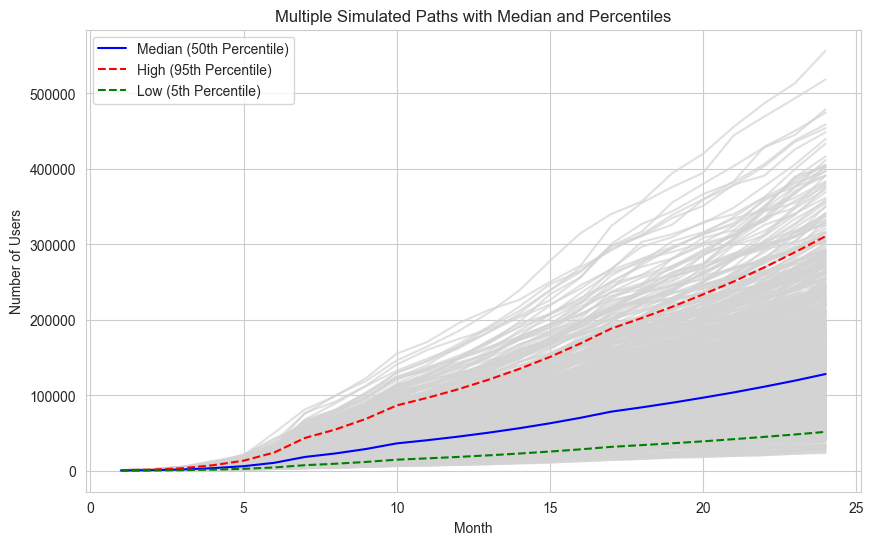

In [4]:
# Set up the seaborn style
sns.set_style("whitegrid")

# Define the figure size
plt.figure(figsize=(10, 6))

# Plot a subset of simulation paths
for i in range(min(1000, num_simulations)):  # Plotting up to 1000 paths
    plt.plot(range(1, 25), all_simulations[i], color='lightgrey', alpha=0.7)

# Overlay percentiles & median lines
plt.plot(range(1, 25), likely_growth, color='b', label='Median (50th Percentile)')
plt.plot(range(1, 25), high_growth, color='r', linestyle='dashed', label='High (95th Percentile)')
plt.plot(range(1, 25), low_growth, color='g', linestyle='dashed', label='Low (5th Percentile)')

# Define the title and labels
plt.title('Multiple Simulated Paths with Median and Percentiles')
plt.xlabel('Month')
plt.ylabel('Number of Users')

# Show the legend
plt.legend()

# Display the plot
plt.show()

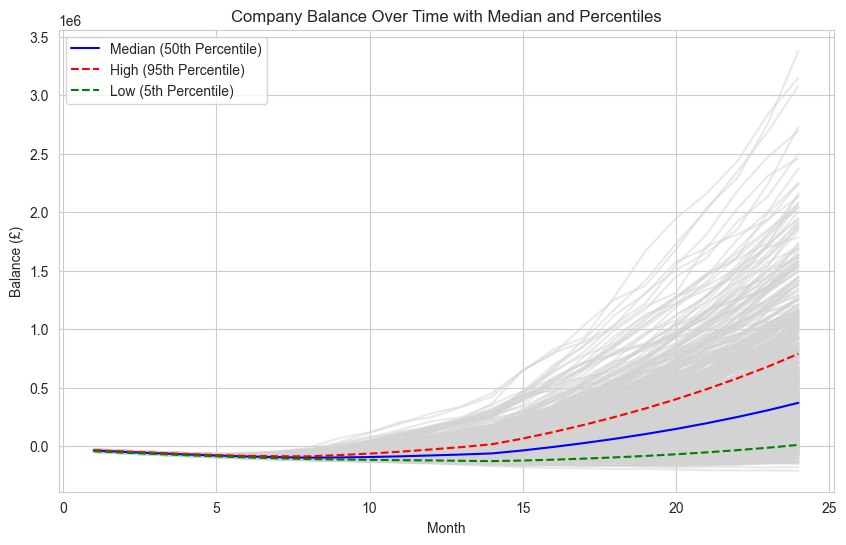

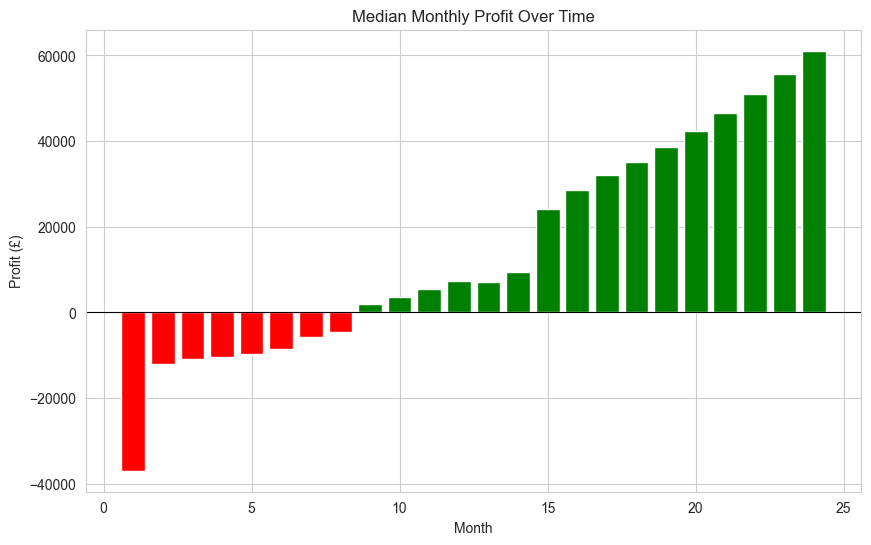

In [5]:
# Number of simulations
num_simulations = 100000

# Definitions for the different growth, subscription, transaction fee, and advertising revenue rates.
growth_rates = {
    3: (30, 80, 200),
    6: (25, 50, 150),
    9: (15, 27, 35),
    16: (5, 10, 20),
    24: (2, 5, 15),
}

sub_rates = {
    2: (0, 0, 0.5),
    8: (0.5, 4.5, 7.5),
    14: (1.5, 8, 11),
    24: (2, 11, 17),
}

trans_fees = {
    6: (0, 0, 0),
    14: (0.002, 0.025, 0.06),
    24: (0.005, 0.05, 0.09),
}

ad_rev_per_user = {
    3: (0, 0, 0),
    24: (0.002, 0.01, 0.035),
}


def get_rate(month, rate_dict):
    for m in sorted(rate_dict.keys()):
        if month < m:
            return rate_dict[m]
    return rate_dict[max(rate_dict.keys())]


def monte_carlo_simulation():
    all_simulations = []
    all_monthly_profits = [] 
    for _ in range(num_simulations):
        users = np.random.triangular(150, 350, 900)
        balance = 0
        monthly_balance = []
        monthly_profits = [] 

        for month in range(24):
            growth_rate = get_rate(month, growth_rates)
            users *= (1 + np.random.triangular(*growth_rate) / 100)

            subscription_rate = get_rate(month, sub_rates)
            if subscription_rate[0] < subscription_rate[2]:  # to ensure left < right
                avg_subbed_users = users * np.random.triangular(*subscription_rate) / 100
            else:
                avg_subbed_users = users * subscription_rate[1] / 100  # use the likely value if left == right
            subscription_revenue = avg_subbed_users * 5  # 5 GBP per subscribed user

            transaction_fee = get_rate(month, trans_fees)
            if transaction_fee[0] < transaction_fee[2]:  # to ensure left < right
                transaction_revenue = users * np.random.triangular(*transaction_fee)
            else:
                transaction_revenue = users * transaction_fee[1]  # use the likely value if left == right

            ad_rate = get_rate(month, ad_rev_per_user)
            if ad_rate[0] < ad_rate[2]:  # to ensure left < right
                advertising_revenue = users * np.random.triangular(*ad_rate)
            else:
                advertising_revenue = users * ad_rate[1]  # use the likely value if left == right

            total_revenue = subscription_revenue + transaction_revenue + advertising_revenue
            total_cost = get_costs(month, users)

            monthly_profit = total_revenue - total_cost
            balance += monthly_profit
            monthly_balance.append(balance)
            monthly_profits.append(monthly_profit)
        
        all_simulations.append(monthly_balance)
        all_monthly_profits.append(monthly_profits)

    return np.array(all_simulations), np.array(all_monthly_profits)

#CHANGE HERE
def get_costs(month, users):
    platform_development = np.random.triangular(11000, 17000, 30000) if month == 0 else (np.random.triangular(1500, 2500, 4000) if month < 6 else 0)
    marketing = np.random.triangular(5000, 10000, 15000) if month == 0 else np.random.triangular(1000 if month == 1 else 400, 1500 if month == 1 else 800, 2000)
    server_hosting = np.random.triangular(100, 150, 200) if month == 0 else (np.random.triangular(110, 160, 250) if users < 5000 else (np.random.triangular(400, 550, 700) if users < 15000 else np.random.triangular(900, 1100, 2500)))
    maintenance = np.random.triangular(400, 600, 1000) if month < 6 else np.random.triangular(600, 1000, 2000)
    advisory_legal = np.random.triangular(1000, 1200, 2500) if month == 0 else np.random.triangular(250 if month < 6 else 500, 1800 if month < 6 else 2000, 2500 if month < 6 else 3500)
    employee = np.random.triangular(4000, 5500, 7000 if month < 6 else (8000 if month < 12 else 16000))
    
    return platform_development + marketing + server_hosting + maintenance + advisory_legal + employee


def plot_simulations(all_simulations):
    # Extract percentiles and median
    low_balance = np.percentile(all_simulations, 10, axis=0)
    high_balance = np.percentile(all_simulations, 80, axis=0)
    median_balance = np.median(all_simulations, axis=0)

    # Plotting
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    for i in range(min(1000, num_simulations)):
        plt.plot(range(1, 25), all_simulations[i], color='lightgrey', alpha=0.5)

    plt.plot(range(1, 25), median_balance, color='b', label='Median (50th Percentile)')
    plt.plot(range(1, 25), high_balance, color='r', linestyle='dashed', label='High (95th Percentile)')
    plt.plot(range(1, 25), low_balance, color='g', linestyle='dashed', label='Low (5th Percentile)')

    plt.title('Company Balance Over Time with Median and Percentiles')
    plt.xlabel('Month')
    plt.ylabel('Balance (£)')

    plt.legend()
    plt.show()

def plot_monthly_profit(all_profits):
    # Extract percentiles and median
    median_profit = np.median(all_profits, axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_colors = ['g' if profit >= 0 else 'r' for profit in median_profit]
    plt.bar(range(1, 25), median_profit, color=bar_colors)
    plt.title('Median Monthly Profit Over Time')
    plt.xlabel('Month')
    plt.ylabel('Profit (£)')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.show()

# Running the Monte Carlo simulation and plotting results
all_simulations,all_profits = monte_carlo_simulation()
plot_simulations(all_simulations)
plot_monthly_profit(all_profits)

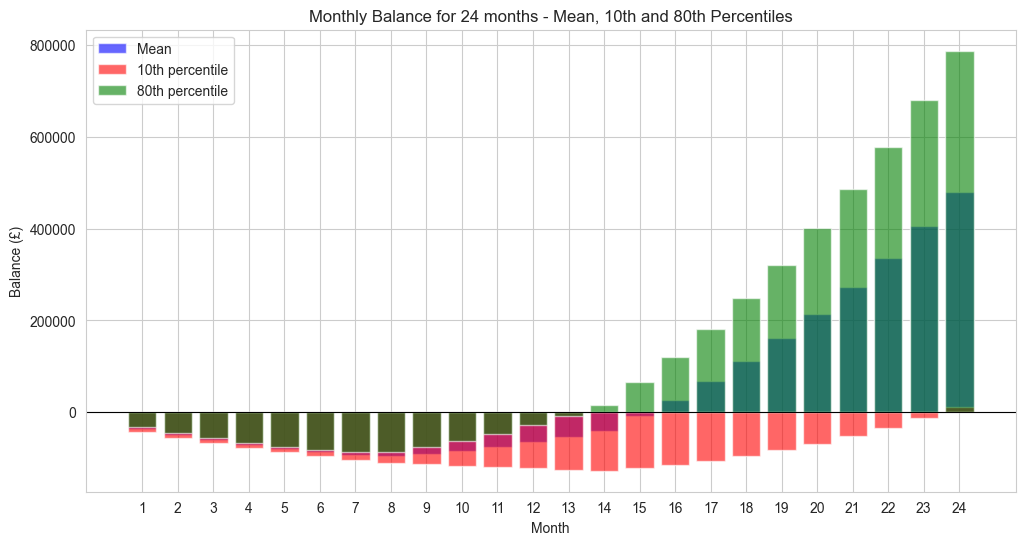

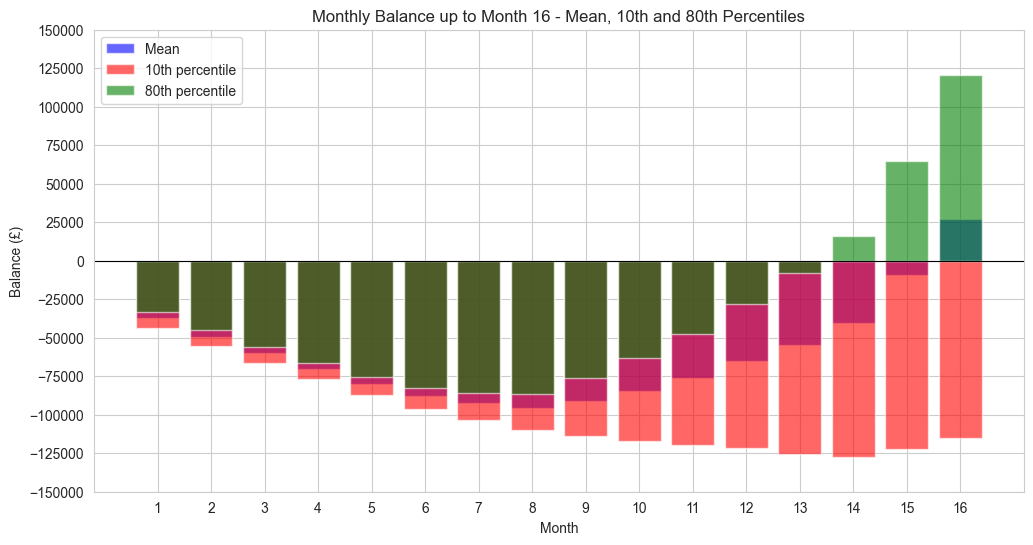

In [6]:
def plot_bar_chart(all_simulations):
    simulations = all_simulations[0]
    
    means = simulations.mean(axis=0)
    lower_bound = np.percentile(simulations, 10, axis=0)  # 10th percentile
    upper_bound = np.percentile(simulations, 80, axis=0)  # 80th percentile
    
    # Full 24 months
    plt.figure(figsize=(12,6))
    plt.bar(range(1, 25), means, color='b', alpha=0.6, label='Mean')
    plt.bar(range(1, 25), lower_bound, color='r', alpha=0.6, label='10th percentile')
    plt.bar(range(1, 25), upper_bound, color='g', alpha=0.6, label='80th percentile')
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel('Month')
    plt.ylabel('Balance (£)')
    plt.title('Monthly Balance for 24 months - Mean, 10th and 80th Percentiles')
    plt.legend(loc='upper left')
    plt.xticks(range(1, 25))
    plt.show()

    # Zoomed-in up until the company turns profitable
    profitable_month = next((i for i, value in enumerate(means) if value > 0), len(means))
    if profitable_month < 24:
        plt.figure(figsize=(12,6))
        plt.bar(range(1, profitable_month + 2), means[:profitable_month + 1], color='b', alpha=0.6, label='Mean')
        plt.bar(range(1, profitable_month + 2), lower_bound[:profitable_month + 1], color='r', alpha=0.6, label='10th percentile')
        plt.bar(range(1, profitable_month + 2), upper_bound[:profitable_month + 1], color='g', alpha=0.6, label='80th percentile')
        
        plt.axhline(0, color='black', linewidth=0.8)
        plt.xlabel('Month')
        plt.ylabel('Balance (£)')
        plt.title(f'Monthly Balance up to Month {profitable_month + 1} - Mean, 10th and 80th Percentiles')
        plt.legend(loc='upper left')
        plt.xticks(range(1, profitable_month + 2))
        current_ticks = plt.yticks()[0]
        new_ticks = np.linspace(min(current_ticks), max(current_ticks), num=len(current_ticks)*2 - 1)
        plt.yticks(new_ticks)
        plt.show()

# Running the Monte Carlo simulation and plotting results
all_simulations = monte_carlo_simulation()
plot_bar_chart(all_simulations)

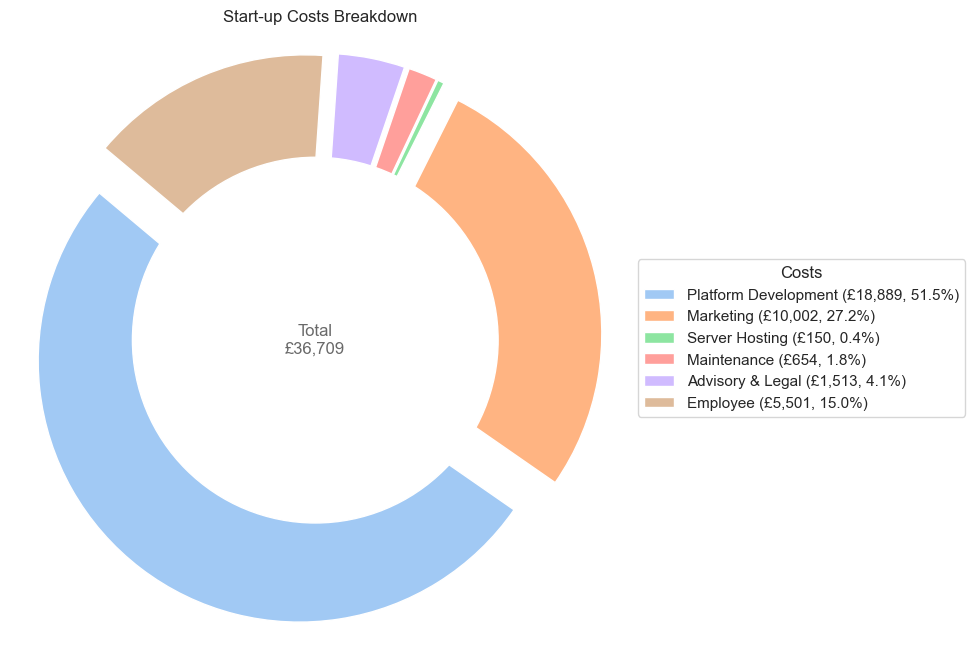

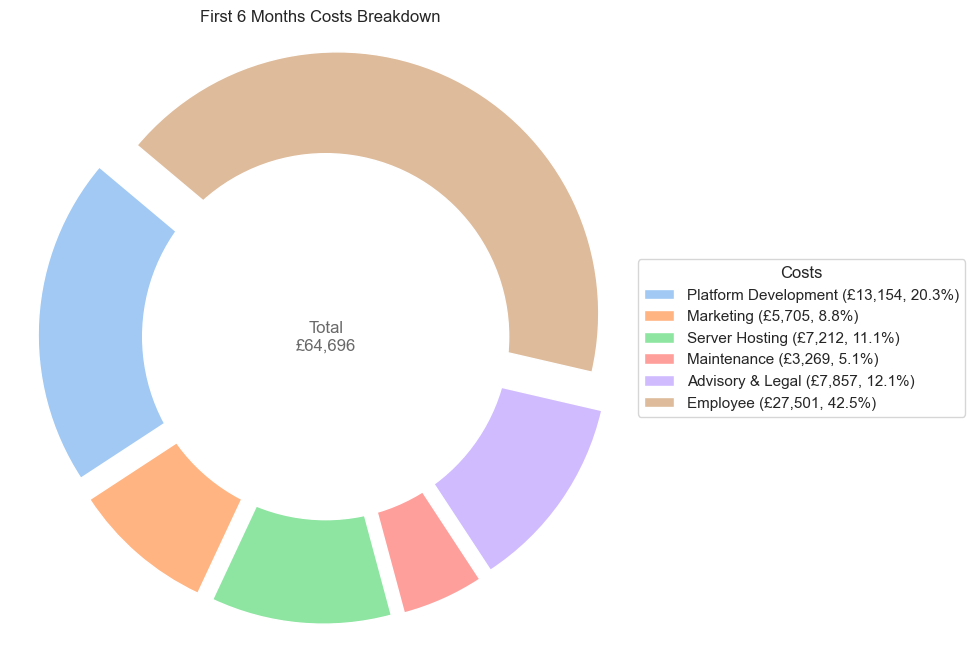

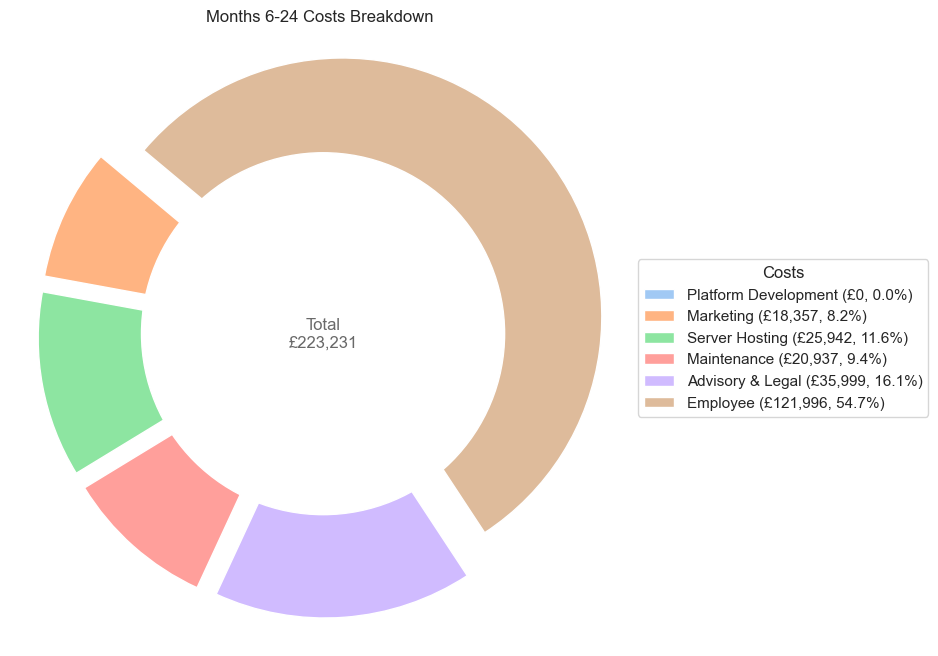

In [9]:
def plot_cost_breakdown(start_month, end_month, title):
    all_costs = {
        "Platform Development": [],
        "Marketing": [],
        "Server Hosting": [],
        "Maintenance": [],
        "Advisory & Legal": [],
        "Employee": []
    }
    
    users = np.random.triangular(150, 350, 900)  # initial users
    
    for _ in range(num_simulations):
        for month in range(start_month, end_month):
            users *= (1 + np.random.triangular(*get_rate(month, growth_rates)) / 100)
            
            platform_development, marketing, server_hosting, maintenance, advisory_legal, employee = get_individual_costs(month, users)
            
            all_costs["Platform Development"].append(platform_development)
            all_costs["Marketing"].append(marketing)
            all_costs["Server Hosting"].append(server_hosting)
            all_costs["Maintenance"].append(maintenance)
            all_costs["Advisory & Legal"].append(advisory_legal)
            all_costs["Employee"].append(employee)

    median_costs = {key: np.median(value) * (end_month - start_month) for key, value in all_costs.items()}
    total_cost = sum(median_costs.values())
    
    sns.set(style="whitegrid")
    colors = sns.color_palette("pastel")

    plt.figure(figsize=(8,8))
    wedges, texts = plt.pie(median_costs.values(), startangle=140, explode=[0.1]*6, colors=colors)
    plt.axis('equal') 
    
    # Draw center circle for 'donut' style and add total cost in the middle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.text(0, 0, f"Total\n£{total_cost:,.0f}", ha='center', va='center', fontsize=12, color='dimgrey')
    
    plt.title(title)
    
    # Including percentages in the legend
    labels_with_percentages = [f"{key} (£{value:,.0f}, {value/total_cost:.1%})" for key, value in median_costs.items()]
    plt.legend(wedges, labels_with_percentages, title="Costs", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.show()

def get_individual_costs(month, users):
    platform_development = np.random.triangular(11000, 17000, 30000) if month == 0 else (np.random.triangular(1500, 2500, 4000) if month < 6 else 0)
    marketing = np.random.triangular(5000, 10000, 15000) if month == 0 else np.random.triangular(1000 if month == 1 else 400, 1500 if month == 1 else 800, 2000)
    server_hosting = np.random.triangular(100, 150, 200) if month == 0 else (np.random.triangular(110, 160, 250) if users < 5000 else (np.random.triangular(400, 550, 700) if users < 15000 else np.random.triangular(900, 1100, 2500)))
    maintenance = np.random.triangular(400, 600, 1000) if month < 6 else np.random.triangular(600, 1000, 2000)
    advisory_legal = np.random.triangular(1000, 1200, 2500) if month == 0 else np.random.triangular(250 if month < 6 else 500, 1800 if month < 6 else 2000, 2500 if month < 6 else 3500)
    employee = np.random.triangular(4000, 5500, 7000 if month < 6 else (8000 if month < 12 else 16000))
    
    return platform_development, marketing, server_hosting, maintenance, advisory_legal, employee

plot_cost_breakdown(0, 1, 'Start-up Costs Breakdown')
plot_cost_breakdown(1, 6, 'First 6 Months Costs Breakdown')
plot_cost_breakdown(6, 24, 'Months 6-24 Costs Breakdown')

In [ ]:
import pandas as pd

# Revenues Data
revenues_data = {
    "Month Range": ["1-2", "3-8", "9-14", "15-24"],
    "Avg Subscribed Users (%)": ["Min: 0 Likely: 0 Max: 0.5", "Min: 0.5 Likely: 4.5 Max: 7.5", "Min: 1.5 Likely: 8 Max: 11", "Min: 2 Likely: 11 Max: 17"],
    "Avg Transaction Fees (£)": ["Min: 0 Likely: 0 Max: 0", "Min: 0 Likely: 0 Max: 0", "Min: 0.002 Likely: 0.025 Max: 0.06", "Min: 0.005 Likely: 0.05 Max: 0.09"],
    "Avg Advertising Revenue per User (£)": ["Min: 0 Likely: 0 Max: 0", "Min: 0 Likely: 0 Max: 0", "Min: 0 Likely: 0 Max: 0", "Min: 0.002 Likely: 0.01 Max: 0.035"]
}
revenues_df = pd.DataFrame(revenues_data)

# Costs Data
costs_data = {
    "Month Range": ["0", "1-6", "7-12", "13-24"],
    "Platform Development (£)": ["Min: 11000 Likely: 17000 Max: 30000", "Min: 1500 Likely: 2500 Max: 4000", "0", "0"],
    "Marketing (£)": ["Min: 10000 Likely: 15000 Max: 22000", "Min: 400 Likely: 800 (Month 1: Likely: 1500) Max: 2000", "Min: 400 Likely: 800 Max: 2000", "Min: 400 Likely: 800 Max: 2000"],
    "Server Hosting (£)": ["Min: 100 Likely: 150 Max: 200", "Conditional: - Users < 5000: Min: 110 Likely: 160 Max: 250 - 5000 < Users < 15000: Min: 400 Likely: 550 Max: 700 - Users > 15000: Min: 900 Likely: 1100 Max: 2500", "Same as 1-6", "Same as 1-6"],
    "Maintenance (£)": ["0", "Min: 400 Likely: 600 Max: 1000", "Min: 600 Likely: 1000 Max: 2000", "Min: 600 Likely: 1000 Max: 2000"],
    "Advisory/Legal (£)": ["Min: 1000 Likely: 1200 Max: 2500", "Min: 250 Likely: 1800 Max: 2500", "Min: 500 Likely: 2000 Max: 3500", "Min: 500 Likely: 2000 Max: 3500"],
    "Employee (£)": ["Min: 4000 Likely: 5500 Max: 7000", "Min: 4000 Likely: 5500 Max: 7000", "Min: 4000 Likely: 5500 Max: 8000", "Min: 9000 Likely: 11500 Max: 16000"]
}
costs_df = pd.DataFrame(costs_data)

# Display the dataframes

revenues_df

,Month Range,Avg Subscribed Users (%),Avg Transaction Fees (£),Avg Advertising Revenue per User (£)
0,1-2,Min: 0 Likely: 0 Max: 0.5,Min: 0 Likely: 0 Max: 0,Min: 0 Likely: 0 Max: 0
1,3-8,Min: 0.5 Likely: 4.5 Max: 7.5,Min: 0 Likely: 0 Max: 0,Min: 0 Likely: 0 Max: 0
2,9-14,Min: 1.5 Likely: 8 Max: 11,Min: 0.002 Likely: 0.025 Max: 0.06,Min: 0 Likely: 0 Max: 0
3,15-24,Min: 2 Likely: 11 Max: 17,Min: 0.005 Likely: 0.05 Max: 0.09,Min: 0.002 Likely: 0.01 Max: 0.035


In [ ]:
# User Growth Rate Parameters
growth_rates_data = {
    "Month": ["1-3", "4-6", "7-9", "10-16", "17-24"],
    "Min (%)": [30, 25, 15, 5, 2],
    "Likely (%)": [80, 50, 27, 10, 5],
    "Max (%)": [200, 150, 35, 20, 15]
}

growth_rates_df = pd.DataFrame(growth_rates_data)
growth_rates_df

,Month,Min (%),Likely (%),Max (%)
0,1-3,30,80,200
1,4-6,25,50,150
2,7-9,15,27,35
3,10-16,5,10,20
4,17-24,2,5,15
